###### Content under Creative Commons Attribution license CC-BY 4.0, code under BSD 3-Clause License © 2018 D. Koehn, notebook style sheet by L.A. Barba, N.C. Clementi

###### Translated by Huizhe Di @ SCSIO

# 等间距的笛卡尔网格

在 [lecture 1](https://github.com/daniel-koehn/Theory-of-seismic-waves-II/tree/master/01_Analytical_solutions)，我们回顾了描述波在各向同性弹性介质和声波介质中传播的正问题。此外，推导了均匀三维、二维和一维声学介质的解析解，以验证我们在课程后面开发的有限差分编码的准确性。

在介绍有限差分建模的基础知识之前，我想先概述一下生成离散地下模型的一些概念。

## 从连续到离散的世界  

我们以前建立的偏微分方程描述波在连续介质中的传播。然而，由于计算机只能计算离散问题的限制，如果我们想在计算机上求解这些方程，就必须对连续体进行离散化。问题是，为了得到准确的地震建模结果，我们必须将连续体离散到何种程度?

我们需要离散到分子尺度吗? 例如12克的碳同位素C12有 $6.022140857x10^{23}$ 个原子. 让我们假设我们可以用一个双精度浮点数来表示原子在每个方向上的坐标，这需要8字节，所以我们总共需要 ...

In [1]:
memory_mole_c12 = 6.022140857e23 * 3 * 8 * 1e-12
print ("Memory required = ", memory_mole_c12, " TB")

Memory required =  14453138056800.0  TB


$1.4x10^{13}$ TB 当使用如此精细的网格时，这将导致一些严重的内存问题,我们甚至没有考虑这样一个地震模型运行所需的运行时间。

幸运的是，我们不必为了得到合理的建模结果而将宇宙离散到原子或分子尺度。在以后的讲座中，我们将推导出在建模结果的准确性和模型离散化水平之间寻找最佳折衷的标准。

## 二维模型的离散化

让我们从二维声学的波动方程开始:

\begin{equation}
\frac{\partial^2 P(x,z,t)}{\partial t^2} - Vp^2(x,z) \biggl(\frac{\partial^2 P(x,z,t)}{\partial x^2} + \frac{\partial^2 P(x,z,t)}{\partial z^2} \biggl)= f \nonumber
\end{equation}

在使用有限差分解决这个问题的第一步中，我们必须在特定时间离散化压力波场 $P(x,z,t)$ 和 $V_{p0}(x,z)$ 在特定时间 t 在一个 **等间距二维笛卡尔空间网格**:


<img src="images/2D-grid_cart_ac.png" width="75%">

在这里，模型中离散点的位置信息 (x,z)

\begin{align}
x &= i*dh,\nonumber \\
z &= j*dh,\nonumber \\
\end{align}

$dh$ 为离散点的间距. 我们在一个离散点上表示压力波场和p波速度的值通过 $P_{j,i}$ 和 $Vp_{j,i}$ 定义的。这些是二维矩阵，所以我们可以简单地将它们存储在二维数组中. 让我们在Python中尝试一下.

In [3]:
# Import Libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Here, I introduce a new library, which is useful 
# to define the fonts and size of a figure in a notebook
from pylab import rcParams

# 消除Matplotlib弃用警告
import warnings
warnings.filterwarnings("ignore")

我们要离散一个均匀的地下模型：x = 1000 m，z = 500 m，间距dh = 50 m.

In [4]:
# Define FD grid parameters
dh = 50.0
Xmax = 1000.0
Zmax = 500.0

In [5]:
# Define no. of grid points in x- and z-direction and grid point coordinates
def coord_def(Xmax,Zmax,dh):
    
    # number of grid points in x- and z-direction
    NX = (int)(Xmax / dh)
    NZ = (int)(Zmax / dh)
    
    print("NX = ",NX)
    print("NZ = ",NZ)
    
    # x- and z-coordinates of the discrete Cartesian grid points
    x = np.arange(0, (NX+1)*dh, dh)
    z = np.arange(0, (NZ+1)*dh, dh)
    
    XX, ZZ = np.meshgrid(x, z)
    
    return NX, NZ, x, z, XX, ZZ

NX =  20
NZ =  10


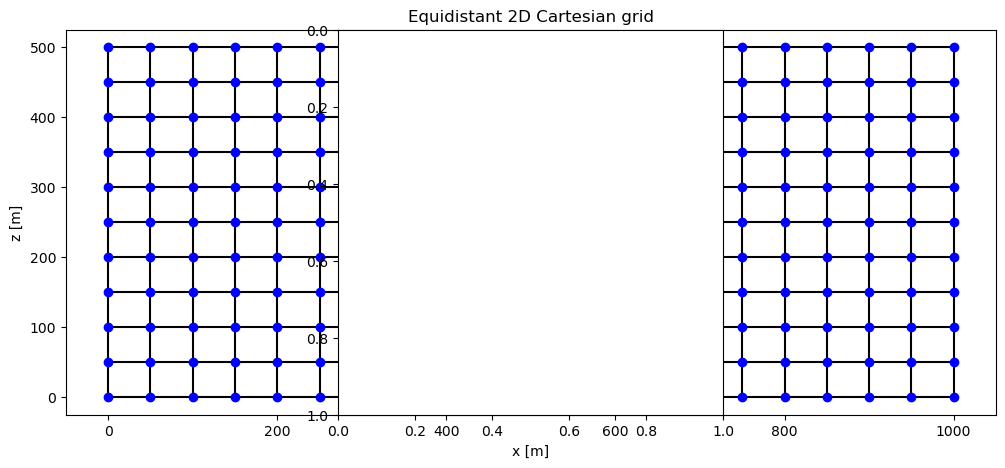

In [6]:
# Define figure size
rcParams['figure.figsize'] = 12, 5

# Calculate coordinates of grid points
NX, NZ, x, z, XX, ZZ = coord_def(Xmax,Zmax,dh)

# Plot Cartesian mesh
plt.plot(XX, ZZ, 'k')
plt.plot(XX.T, ZZ.T, 'k')

# Plot grid points
plt.plot(XX, ZZ, 'bo')

plt.title("Equidistant 2D Cartesian grid" )
plt.xlabel("x [m]")
plt.ylabel("z [m]")
plt.axes().set_aspect('equal')
plt.gca().invert_yaxis()
plt.show()

很好，接下来我们创建并可视化一个在笛卡尔网格上离散的均匀Vp模型。

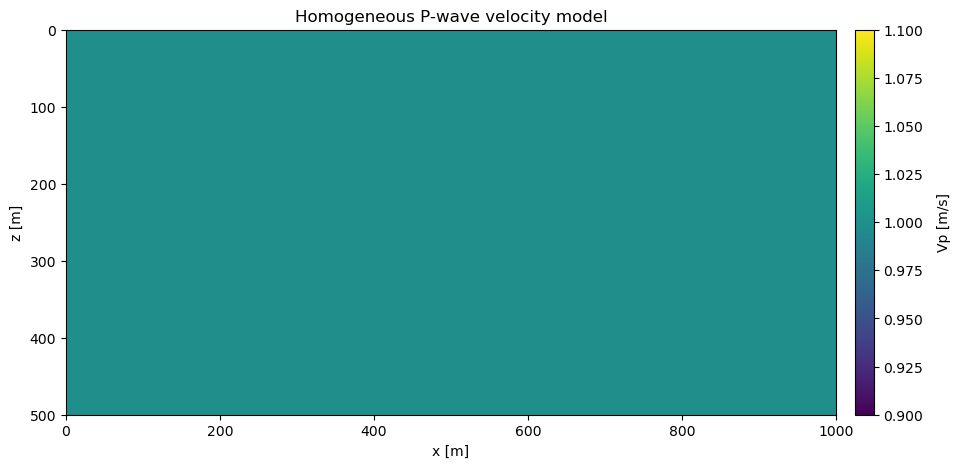

In [7]:
# Define P-wave velocity for homogeneous medium
vp0 = 1.0 # Vp [m/s]
vp = vp0*np.ones((NZ+1,NX+1))

# Plot Vp-model
cax = plt.imshow(vp,extent=[x[0],x[-1],z[0],z[-1]], origin='lower')
plt.title("Homogeneous P-wave velocity model" )
plt.xlabel("x [m]")
plt.ylabel("z [m]")
cbar = plt.colorbar(cax, orientation='vertical', pad=0.02)
cbar.set_label('Vp [m/s]', labelpad=10)
plt.gca().invert_yaxis()
plt.show()

嗯，看起来有点无聊，所以让我们建立一个更有趣的模型-例如在半空间上的一个层:

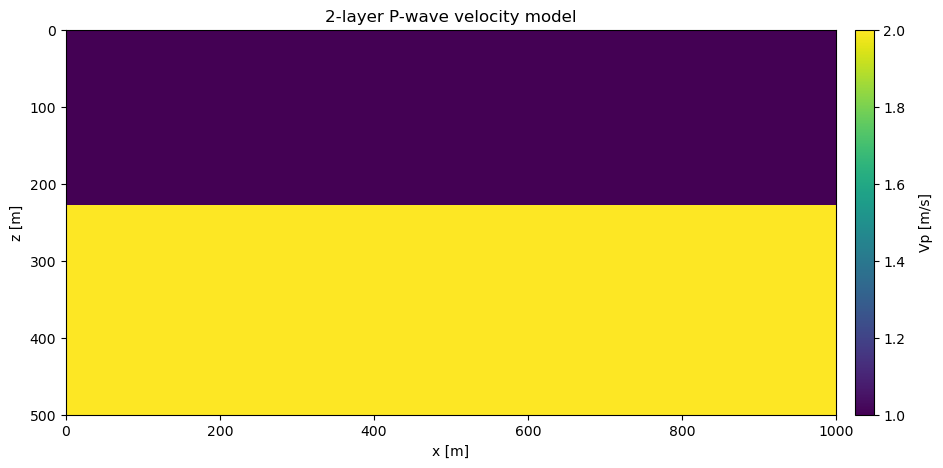

In [8]:
# Define P-wave velocity for homogeneous medium
vp1 = 2.0 # Vp in half-space [m/s]

# Add half-space to model
vp_2layer = vp

vp_2layer[int((NZ+1)/2):NZ+1,:] = vp1

# Plot Vp-model
cax = plt.imshow(vp_2layer,extent=[x[0],x[-1],z[0],z[-1]], origin='lower')
plt.title("2-layer P-wave velocity model" )
plt.xlabel("x [m]")
plt.ylabel("z [m]")
cbar = plt.colorbar(cax, orientation='vertical', pad=0.02)
cbar.set_label('Vp [m/s]', labelpad=10)
plt.gca().invert_yaxis()
plt.show()

... 或者更复杂的界面:

In [9]:
# Define 2-layer P-wave velocity model with sine-shape layer interface
vp1 = 2.0                   # Vp in half-space [m/s]
depth_layer = 250.0         # average depth of sine layer interface
amp = 100.0                 # amplitude of sine layer undulation
wave = 2.0 * np.pi / 100.0  # angular wavenumber of sine undulation

# define function to create model with undulating sine-shaped interface
def create_sin_model(NXtmp,NZtmp,DH):

    # define homogeneous medium
    model = vp0*np.ones((NZtmp+1,NXtmp+1))

    # Add a layer interface undulating with a sine function to model
    # loop over Cartesian grid
    for j in range(NZtmp+1):
        for i in range(NXtmp+1):
        
            depth = j*DH
            x = i*DH
        
            # estimate depth of sine layer interface @ x
            depth_sine = depth_layer + amp * np.sin(wave*x)
        
            if(depth>depth_sine):
                model[j,i] = vp1 
                
    return model

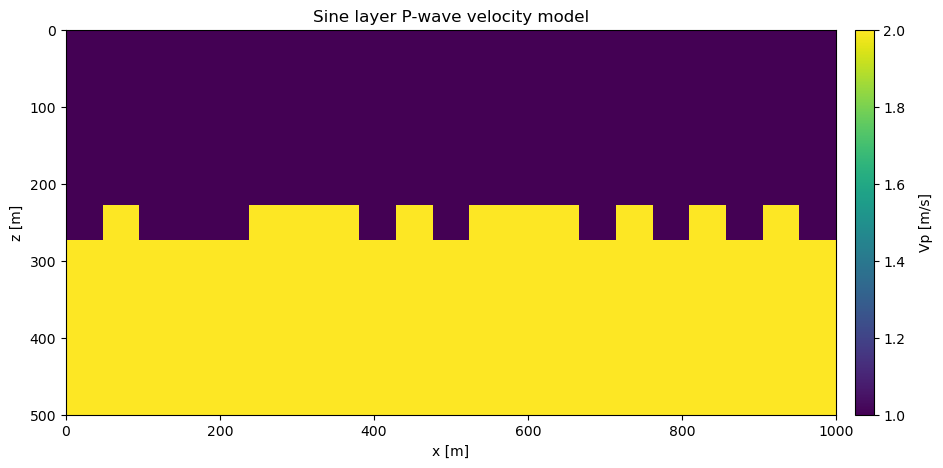

In [10]:
# Create Vp-model
vp_sine = create_sin_model(NX,NZ,dh)

# Plot Vp-model
cax = plt.imshow(vp_sine,extent=[x[0],x[-1],z[0],z[-1]], origin='lower')
plt.title("Sine layer P-wave velocity model" )
plt.xlabel("x [m]")
plt.ylabel("z [m]")
cbar = plt.colorbar(cax, orientation='vertical', pad=0.02)
cbar.set_label('Vp [m/s]', labelpad=10)
plt.gca().invert_yaxis()
plt.show()

这个模型似乎有问题。虽然有一个起伏的层界面，但它并没有正确地遵循定义的正弦形状。其原因是模型的空间采样不足。让我们尝试一个更精细的模型离散化:

NX =  200
NZ =  100


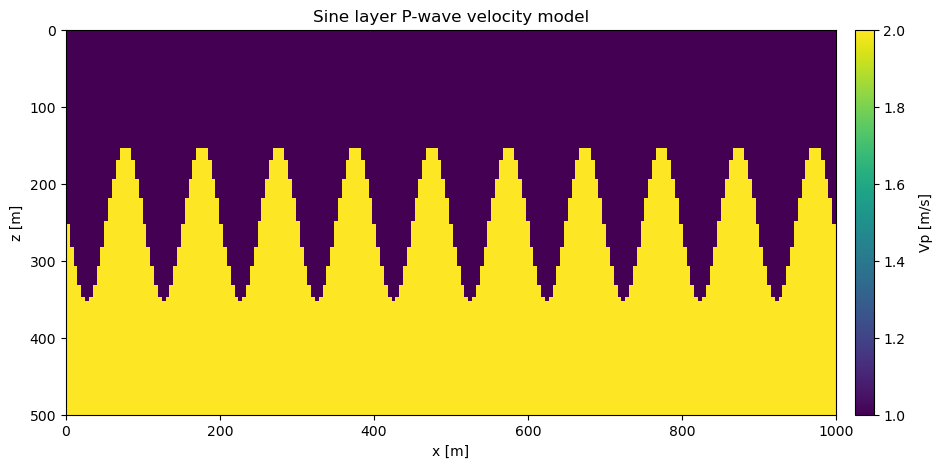

In [11]:
# Create model with finer discretization

# Define new FD grid parameters
dh1 = 5.0
Xmax = 1000.0
Zmax = 500.0

# Calculate coordinates of grid points
NX1, NZ1, x1, z1, XX1, ZZ1 = coord_def(Xmax,Zmax,dh1)

# Define model with finer discretization
vp_sine1 = create_sin_model(NX1,NZ1,dh1)

# Plot Vp-model
cax = plt.imshow(vp_sine1, extent=[x1[0],x1[-1],z1[0],z1[-1]], origin='lower')
plt.title("Sine layer P-wave velocity model" )
plt.xlabel("x [m]")
plt.ylabel("z [m]")
cbar = plt.colorbar(cax, orientation='vertical', pad=0.02)
cbar.set_label('Vp [m/s]', labelpad=10)
plt.gca().invert_yaxis()
# plt.savefig('vp_sine1.pdf', bbox_inches='tight', format='pdf')
plt.show()

看起来好多了，但是界面还是很粗糙。这是笛卡尔网格的一个严重缺点，因此也是有限差分方法的缺点。这些“阶梯”离散化误差会导致人工衍射，成为地震建模中的一个问题。尝试通过使用更精细的模型离散化来最小化楼梯构件。

## 我们学习到:

* 创建二维笛卡尔网格和P波速度模型
* 可视化离散模型
* 笛卡尔网格在精确离散与笛卡尔坐标轴不重合的复杂层界面方面有很大的局限性